# TD($\theta$)

There are issues with the TD(0) rule in continuous-time. Consider an example where the reward rate signal is always zero. By definition, the value function should also be constantly zero. However, $V(t)=c_1 \gamma^{-t}$ is a solution to $\delta^{(0)}(t) = r(t) + \log(\gamma) V(s(t)) + \frac{dV(s(t))}{dt}=0$ in this case. If the value function is represented by a noisy neural population, it will drift from its initialization of zero, and applying TD(0) will result in exponential growth of the value function and unbounded error. Thus, we will explore alternative TD rules.

In discrete-time, an update that uses a longer sequence of rewards is the n-step TD error estimate, TD(n):
$$\delta_t^{(n)} = \underbrace{R_t + \gamma R_{t+1} + \dots + \gamma^{n-1} R_{t+n-1} + \gamma^n V(s_{t+n})}_{=G^{(n)}_t} - V(s_t) $$

In continuous-time, rather than using the instantaneous reward rate to update the value estimate (derived by clipping the integral at $\Delta t \rightarrow 0$), we can integrate the reward signal over a $\theta$ second time window to estimate returns,
\begin{align}
V(s(t-\theta)) \leftarrow V(s(t-\theta)) + \lambda \underbrace{\left [\int_{k=0}^{\theta} \gamma^k r(t+k-\theta) dk + \gamma^{\theta} V(s(t)) - V(s(t-\theta)) \right ]}_{=\delta^{(\theta)}(t)}.
\end{align}
We will call this the TD($\theta$) rule -- a continuous-time version of the TD($n$) rule (Zhou, 2021). The discounted integral over the reward rate history can be directly computed from its \LMU representation and used to drive PES learning: 
\begin{align}
G^{(\theta)}(t-\theta) &= \left ( \frac{1}{\theta} \int_{0}^{1} \gamma^{\theta(1 - \tau)} \mathbf{P}^{q_r}(\tau) d\tau \right )\mathbf{m}_r(t) + \gamma^{\theta}V(s(t)) \\
\delta^{(\theta)}(t-\theta) &= \left ( \frac{1}{\theta} \int_{0}^{1} \gamma^{\theta(1 - \tau)} \mathbf{P}^{q_r}(\tau) d\tau \right )\mathbf{m}_r(t) + \gamma^{\theta}V(s(t)) - \mathbf{P}^{q_v}(1) \mathbf{m}_v(t) \\
 \Delta \mathbf{d}_i(t) &=  \kappa  \delta^{(\theta)}(t-\theta) \mathbf{P}^{q_a}(1) \mathbf{m}_{a_j}(t) 
\end{align}
As written above, this continuously updates the value estimates in the past using all information obtained since. The TD($\theta$) could alternatively be used while state memory is replayed or sampled (see the notebook 'TD(theta) - learning with replay'). 

## Example
Here's a simple example problem. An agent travels around a circle and gets a reward when it is near some particular spot. Our network should learn a value function that anticipates this reward.

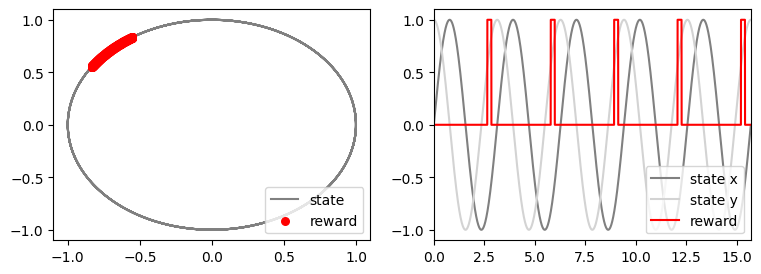

In [1]:
%matplotlib inline
import sys,os
sys.path.insert(1, os.path.dirname(os.getcwd()))
import matplotlib.pyplot as plt
import numpy as np
import nengo
from online_rl_networks import ValueCritic, NeuralValueCritic, sparsity_to_x_intercept


## Very simple RL problem for testing: Go around a circle and get reward at particular spots
# The state is (x,y) position 
T=np.pi*5
dt = 0.001
timesteps = np.arange(0,T,dt)
def sim_fun(t):
    return np.stack([np.sin(t*2), np.cos(t*2)]).T
sim_path = sim_fun(timesteps)

def reward_fun(t):
    if isinstance(t, np.ndarray):
        rewards = np.zeros(len(t))
        rewards[np.sqrt(np.sum((sim_fun(t) - np.array([-0.707,0.707]))**2,axis=1)) < 0.2] = 1
    else:
        rewards = 1 if (np.sqrt(np.sum((sim_fun(t) - np.array([-0.707,0.707]))**2)) < 0.2) else 0
    return rewards

rewards = reward_fun(timesteps)
    
plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
plt.plot(sim_path[:,0],sim_path[:,1], label='state',zorder=1,color='grey')
plt.scatter(sim_path[rewards>0,0], sim_path[rewards>0,1], label='reward',s=30,zorder=2, color='red')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(timesteps,sim_path[:,0], label='state x',color='grey')
plt.plot(timesteps,sim_path[:,1], label='state y',color='lightgrey')
plt.plot(timesteps,rewards, label='reward', color='red')
plt.xlim([0,T])
plt.legend(loc='lower right')

Baseline for comparsion:

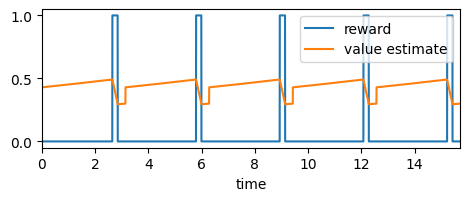

In [2]:
# solution via computing returns
discount  =0.95
returns = [dt*np.sum(discount**(dt*np.arange(len(rewards)-i))*rewards[i:]) for i in range(len(rewards))]

n_period = int(np.pi/dt)
vals_direct=[np.mean([returns[j*n_period + i] for j in range(5)]) for i in range(n_period)]
repeated_vals = np.tile(vals_direct,int(T/np.pi))

plt.figure(figsize=(5.4,1.8))
plt.plot(timesteps,rewards, label='reward')
plt.plot(timesteps[:len(repeated_vals)],repeated_vals, label='value estimate')
plt.xlim([0,T])
plt.xlabel('time')
plt.legend()

In [3]:

n_neurons_state=400
n_neurons_value=400
discount = 0.95
theta = 0.5

q_a = 8
q_r = 8
q_v = 8


model = nengo.Network()
with model:
    state = nengo.Node(sim_fun)
    reward = nengo.Node(reward_fun)

    VL = ValueCritic(n_neurons_state,n_neurons_value, theta, 2, discount, q_a, q_r, q_v,'TDtheta',
                     T_test=9,learning_rate=1e-4, intercepts=nengo.dists.Choice([sparsity_to_x_intercept(2, 0.1)]))
    nengo.Connection(state, VL.state_input, synapse=None)
    nengo.Connection(reward, VL.reward_input, synapse=None)
    
    V_p = nengo.Probe(VL.value, synapse=.05)
    Vmem_p = nengo.Probe(VL.value_memory, synapse=None)
    r_p = nengo.Probe(reward, synapse=None)
    rmem_p = nengo.Probe(VL.reward_memory, synapse=None)
    stateact_p = nengo.Probe(VL.state.neurons, synapse=0.005)
    stateactmem_p = nengo.Probe(VL.state_memory, synapse=None)
    er_p = nengo.Probe(VL.rule, "error", synapse=None)
    

with nengo.Simulator(model,dt=dt) as sim:
    sim.run(T)
ts = sim.trange() 

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Text(0.5, 0, 'Time (s)')

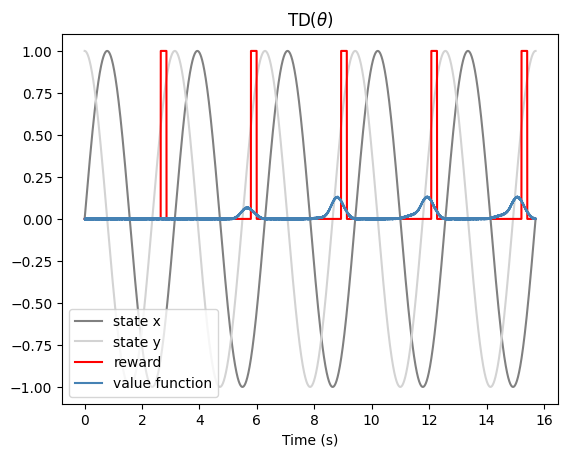

In [4]:
plt.figure()
plt.plot(timesteps,sim_path[:,0], label='state x',color='grey')
plt.plot(timesteps,sim_path[:,1], label='state y',color='lightgrey')
plt.plot(timesteps,rewards, label='reward', color='red')
plt.plot(timesteps, sim.data[V_p], color='steelblue', label='value function')
plt.legend()
plt.title('TD($\\theta$)')
plt.xlabel('Time (s)')
# note that learning is turned off after 9 seconds

It learns to anticipate the reward. Let's try a larger $\theta$:

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Text(0.5, 0, 'Time (s)')

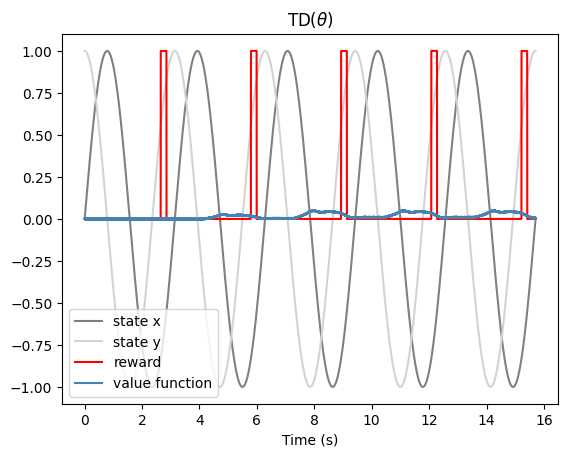

In [5]:
theta = 1.5

model = nengo.Network()
with model:
    state = nengo.Node(sim_fun)
    reward = nengo.Node(reward_fun)

    VL = ValueCritic(n_neurons_state,n_neurons_value, theta, 2, discount, q_a, q_r, q_v,
                     'TDtheta',T_test=9,learning_rate=1e-4, intercepts=nengo.dists.Choice([sparsity_to_x_intercept(2, 0.1)]))
    nengo.Connection(state, VL.state_input, synapse=None)
    nengo.Connection(reward, VL.reward_input, synapse=None)
    
    V_p = nengo.Probe(VL.value, synapse=.05)
    Vmem_p = nengo.Probe(VL.value_memory, synapse=None)
    r_p = nengo.Probe(reward, synapse=None)
    rmem_p = nengo.Probe(VL.reward_memory, synapse=None)
    stateact_p = nengo.Probe(VL.state.neurons, synapse=0.005)
    stateactmem_p = nengo.Probe(VL.state_memory, synapse=None)
    er_p = nengo.Probe(VL.rule, "error", synapse=None)
    

with nengo.Simulator(model,dt=dt) as sim:
    sim.run(T)
ts = sim.trange() 

plt.figure()
plt.plot(timesteps,sim_path[:,0], label='state x',color='grey')
plt.plot(timesteps,sim_path[:,1], label='state y',color='lightgrey')
plt.plot(timesteps,rewards, label='reward', color='red')
plt.plot(timesteps, sim.data[V_p], color='steelblue', label='value function')
plt.legend()
plt.title('TD($\\theta$)')
plt.xlabel('Time (s)')

Zooming in:

Text(0.5, 0, 'Time (s)')

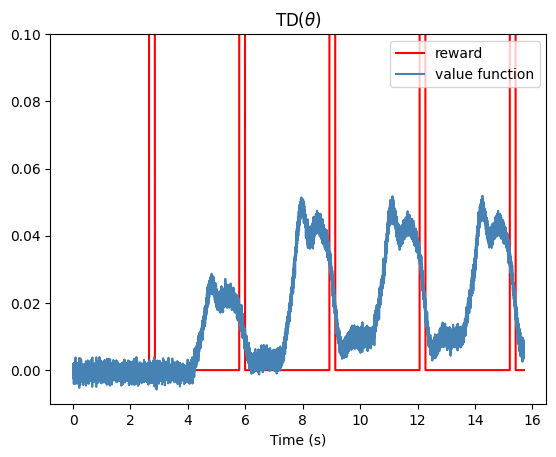

In [6]:

plt.figure()
plt.plot(timesteps,rewards, label='reward', color='red')
plt.plot(timesteps, sim.data[V_p], color='steelblue', label='value function')
plt.ylim([-0.01,0.1])
plt.legend()
plt.title('TD($\\theta$)')
plt.xlabel('Time (s)')

Running longer:

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Text(0.5, 0, 'Time (s)')

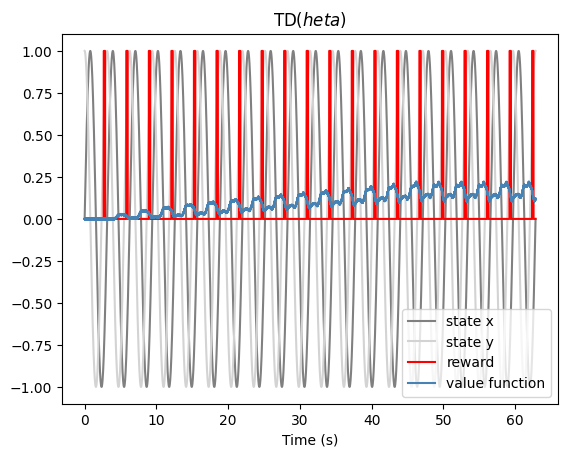

In [7]:
model = nengo.Network()
with model:
    state = nengo.Node(sim_fun)
    reward = nengo.Node(reward_fun)

    VL = ValueCritic(n_neurons_state,n_neurons_value, theta, 2, discount, 
                     q_a, q_r, q_v,'TDtheta',T_test=np.pi*15,learning_rate=1e-4, intercepts=nengo.dists.Choice([sparsity_to_x_intercept(2, 0.1)]))
    nengo.Connection(state, VL.state_input, synapse=None)
    nengo.Connection(reward, VL.reward_input, synapse=None)
    
    V_p = nengo.Probe(VL.value, synapse=.05)
    Vmem_p = nengo.Probe(VL.value_memory, synapse=None)
    r_p = nengo.Probe(reward, synapse=None)
    rmem_p = nengo.Probe(VL.reward_memory, synapse=None)
    stateact_p = nengo.Probe(VL.state.neurons, synapse=0.005)
    stateactmem_p = nengo.Probe(VL.state_memory, synapse=None)
    er_p = nengo.Probe(VL.rule, "error", synapse=None)
    

with nengo.Simulator(model,dt=dt) as sim:
    sim.run(np.pi*20)
ts = sim.trange() 


plt.figure()
plt.plot(ts,sim_fun(ts)[:,0], label='state x',color='grey')
plt.plot(ts,sim_fun(ts)[:,1], label='state y',color='lightgrey')
plt.plot(ts,reward_fun(ts), label='reward', color='red')
plt.plot(ts, sim.data[V_p], color='steelblue', label='value function')
plt.legend()
plt.title('TD($\\theta$)')
plt.xlabel('Time (s)')

## Critic learning with spiking LMU memories

In [11]:
n_neurons_state=400
n_neurons_value=400
n_neurons_lmus = 300
discount = 0.95
theta = 0.5

q_a = 8
q_r = 8
q_v = 8


model = nengo.Network()
with model:
    state = nengo.Node(sim_fun)
    reward = nengo.Node(reward_fun)

    VL = NeuralValueCritic(n_neurons_state,n_neurons_value, n_neurons_lmus, theta, 2, discount, q_a, q_r, q_v,'TDtheta',
                     T_test=9,learning_rate=1e-4, intercepts=nengo.dists.Choice([sparsity_to_x_intercept(2, 0.1)]))
    nengo.Connection(state, VL.state_input, synapse=None)
    nengo.Connection(reward, VL.reward_input, synapse=None)
    
    V_p = nengo.Probe(VL.value, synapse=.05)
    r_p = nengo.Probe(reward, synapse=None)
    

with nengo.Simulator(model,dt=dt) as sim:
    sim.run(T)
ts = sim.trange() 

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Text(0.5, 0, 'Time (s)')

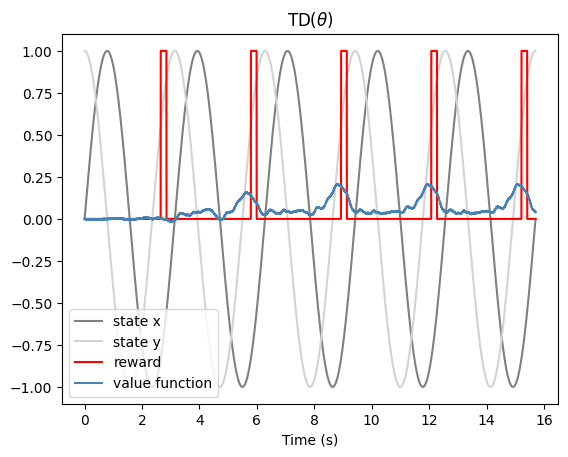

In [13]:

plt.figure()
plt.plot(ts,sim_fun(ts)[:,0], label='state x',color='grey')
plt.plot(ts,sim_fun(ts)[:,1], label='state y',color='lightgrey')
plt.plot(ts,reward_fun(ts), label='reward', color='red')
plt.plot(ts, sim.data[V_p], color='steelblue', label='value function')
plt.legend()
plt.title('TD($\\theta$)')
plt.xlabel('Time (s)')